<a href="https://colab.research.google.com/github/Charlie-Davalos/Multiagentes/blob/main/M1_A01706041.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install mesa

# Importar librerías necesarias
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import SimultaneousActivation
from mesa.datacollection import DataCollector
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Configuración de matplotlib para Colab
%matplotlib inline
plt.rcParams["animation.html"] = "jshtml"

In [8]:
# Definir las clases de agentes
class CleaningAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)

    def step(self):
        cell_content = self.model.grid.get_cell_list_contents([self.pos])
        if any(isinstance(obj, Dirt) for obj in cell_content):
            # Limpiar la celda
            dirt_to_clean = [obj for obj in cell_content if isinstance(obj, Dirt)][0]
            self.model.grid.remove_agent(dirt_to_clean)
        else:
            # Moverse a una celda adyacente aleatoria
            possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
            new_position = random.choice(possible_steps)
            self.model.grid.move_agent(self, new_position)

class Dirt(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)

In [12]:
# Definir el modelo (corregido)
class CleaningModel(Model):
    def __init__(self, width, height, num_agents, dirt_percentage):
        super().__init__()
        self.num_agents = num_agents
        self.grid = MultiGrid(width, height, torus=False)
        self.schedule = SimultaneousActivation(self)
        self.current_id = 0
        self.dirt_percentage = dirt_percentage
        self.datacollector = DataCollector(
            {"Dirt": lambda m: self.count_dirt()}
        )

        # Crear suciedad
        dirt_count = int(width * height * dirt_percentage)
        for _ in range(dirt_count):
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            dirt = Dirt(self.next_id(), self)
            self.grid.place_agent(dirt, (x, y))
            self.schedule.add(dirt)

        # Crear agentes de limpieza
        for _ in range(self.num_agents):
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            agent = CleaningAgent(self.next_id(), self)
            self.grid.place_agent(agent, (x, y))
            self.schedule.add(agent)

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

    def next_id(self):
        self.current_id += 1
        return self.current_id

    def count_dirt(self):
        count = 0
        for cell in self.grid.coord_iter():
            cell_content = cell[0]
            count += sum(1 for obj in cell_content if isinstance(obj, Dirt))
        return count

In [13]:
# Configuración de la simulación
# Parámetros de la simulación
width, height = 20, 20
num_agents_list = [1, 5, 10]
dirt_percentage = 0.80
max_steps = 2000

# Función para ejecutar la simulación y recopilar resultados
def run_simulation(num_agents, max_steps):
    model = CleaningModel(width, height, num_agents, dirt_percentage)
    for i in range(max_steps):
        model.step()
        if model.count_dirt() == 0:
            break
    cleaned_cells = (width * height * dirt_percentage) - model.count_dirt()
    data = model.datacollector.get_model_vars_dataframe()
    return {
        "steps_taken": i + 1,
        "cleaned_cells": cleaned_cells,
        "dirt_left": model.count_dirt(),
        "percentage_clean_after_500": (1 - data["Dirt"].iloc[500] / (width * height * dirt_percentage)) * 100 if 500 < len(data) else None,
        "percentage_clean_after_1000": (1 - data["Dirt"].iloc[1000] / (width * height * dirt_percentage)) * 100 if 1000 < len(data) else None,
        "percentage_clean_after_1500": (1 - data["Dirt"].iloc[1500] / (width * height * dirt_percentage)) * 100 if 1500 < len(data) else None,
    }

results = {}
for num_agents in num_agents_list:
    results[num_agents] = run_simulation(num_agents, max_steps)

# Mostrar resultados
for num_agents, data in results.items():
    print(f"Resultados para {num_agents} agentes:")
    print(f"Pasos realizados: {data['steps_taken']}")
    print(f"Celdas limpiadas: {data['cleaned_cells']}")
    print(f"Suciedad restante: {data['dirt_left']}")
    print(f"Porcentaje limpio después de 500 pasos: {data['percentage_clean_after_500']}")
    print(f"Porcentaje limpio después de 1000 pasos: {data['percentage_clean_after_1000']}")
    print(f"Porcentaje limpio después de 1500 pasos: {data['percentage_clean_after_1500']}")
    print("")

Resultados para 1 agentes:
Pasos realizados: 2000
Celdas limpiadas: 294.0
Suciedad restante: 26
Porcentaje limpio después de 500 pasos: 44.99999999999999
Porcentaje limpio después de 1000 pasos: 72.8125
Porcentaje limpio después de 1500 pasos: 84.6875

Resultados para 5 agentes:
Pasos realizados: 1112
Celdas limpiadas: 320.0
Suciedad restante: 0
Porcentaje limpio después de 500 pasos: 97.8125
Porcentaje limpio después de 1000 pasos: 99.6875
Porcentaje limpio después de 1500 pasos: None

Resultados para 10 agentes:
Pasos realizados: 917
Celdas limpiadas: 320.0
Suciedad restante: 0
Porcentaje limpio después de 500 pasos: 99.375
Porcentaje limpio después de 1000 pasos: None
Porcentaje limpio después de 1500 pasos: None



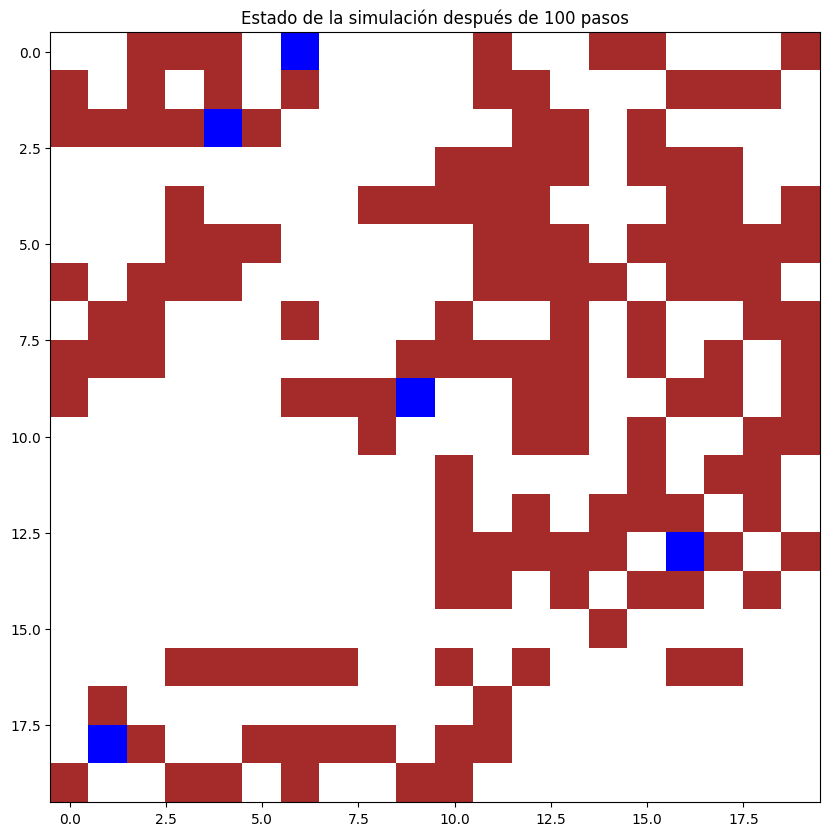

In [15]:
# Visualización de la simulación (corregido)
def plot_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height))
    for cell in model.grid.coord_iter():
        cell_content, (x, y) = cell
        for obj in cell_content:
            if isinstance(obj, Dirt):
                grid[x][y] = 2
            elif isinstance(obj, CleaningAgent):
                grid[x][y] = 1
    return grid

model = CleaningModel(width, height, 5, dirt_percentage)  # Ejemplo con 5 agentes
for i in range(100):  # Ejecutar algunos pasos
    model.step()

grid = plot_grid(model)
cmap = ListedColormap(['white', 'blue', 'brown'])
plt.figure(figsize=(10, 10))
plt.imshow(grid, cmap=cmap, interpolation='nearest')
plt.title("Estado de la simulación después de 100 pasos")
plt.show()